In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree                    import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn                         import linear_model
from sklearn.naive_bayes             import GaussianNB
import lightgbm as lgb
from sklearn.metrics import f1_score,accuracy_score,auc,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from Functions import basic_clean

In [2]:
#get data
df=pd.read_pickle('data.pkl')
df.head()

,Rating,Text,Year,Month,text_clean,text_len
0,5,I have bought several of the Vitality canned d...,2011,4,"[bought, several, vitality, canned, dog, food,...",263
1,1,Product arrived labeled as Jumbo Salted Peanut...,2012,9,"[product, arrived, labeled, jumbo, salted, pea...",190
2,4,This is a confection that has been around a fe...,2008,8,"[confection, around, century, light, pillowy, ...",509
3,2,If you are looking for the secret ingredient i...,2011,6,"[looking, secret, ingredient, robitussin, beli...",219
4,5,Great taffy at a great price. There was a wid...,2012,10,"[great, taffy, great, price, wide, assortment,...",140


In [3]:
# Then we get rid of score 3 reviews (neutral), 
# and separate the remaining reviews into binary class (1 = positive, 0 = negative):
df=df[df['Rating']!=3]
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Rating'].map(y_dict)

In [4]:
# use tfidf to transform the text data
tfidf_vect = TfidfVectorizer(analyzer=basic_clean,ngram_range=(1, 2), stop_words='english',max_df=0.8,min_df=10)
X_tfidf = tfidf_vect.fit_transform(df['Text'])
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, random_state=42)

In [5]:
# Fit each model and get accuracy score and f1 score in the test set
def pred_model(model, accuracy, f1):
    fit = model.fit(X_train, y_train)
    accuracy[model] = accuracy_score(y_test, fit.predict(X_test))
    f1[model] = f1_score(y_test, fit.predict(X_test))

# print all the metrics
def print_result(model, accuracy, f1):
    print('\nModel:\n', model)
    print('Accuracy in the Test Set:\n', accuracy[model])
    print('F-1 Score in the Test Set:\n', f1[model])

In [6]:
# Fit different machine learning models
models = []
accuracy = {}
f1={}
ridge=linear_model.LogisticRegression(penalty='l2',solver='liblinear')
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
lgbc=lgb.LGBMClassifier()
models.extend([ridge,dt,rf, lgbc])
for model in models:
    pred_model(model, accuracy, f1)
    print_result(model, accuracy, f1)


Model:
 LogisticRegression(solver='liblinear')
Accuracy in the Test Set:
 0.9357722092899418
F-1 Score in the Test Set:
 0.9626169465709692

Model:
 DecisionTreeClassifier()
Accuracy in the Test Set:
 0.9081047362575502
F-1 Score in the Test Set:
 0.9457034726404833

Model:
 RandomForestClassifier()
Accuracy in the Test Set:
 0.929290854595524
F-1 Score in the Test Set:
 0.9597059116781328

Model:
 LGBMClassifier()
Accuracy in the Test Set:
 0.9136427951983204
F-1 Score in the Test Set:
 0.9505359477124183


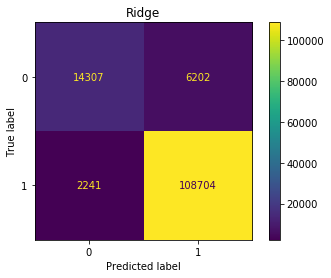

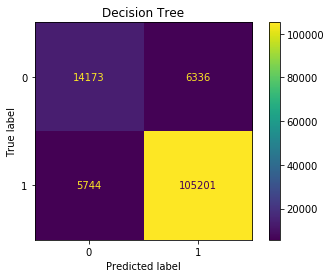

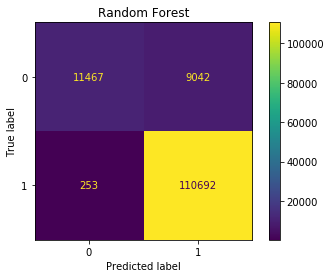

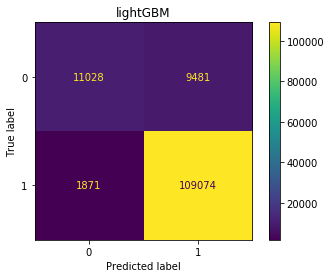

In [10]:
# plot confusion matrix for each model
plot_confusion_matrix(ridge, X_test, y_test)
plt.title('Ridge')
plt.savefig('ridgeconf.png')
plot_confusion_matrix(dt, X_test, y_test)
plt.title('Decision Tree')
plt.savefig('dtconf.png')
plot_confusion_matrix(rf, X_test, y_test)
plt.title('Random Forest')
plt.savefig('rfconf.png')
plot_confusion_matrix(lgbc, X_test, y_test)
plt.title('lightGBM')
plt.savefig('lightGBM.png')

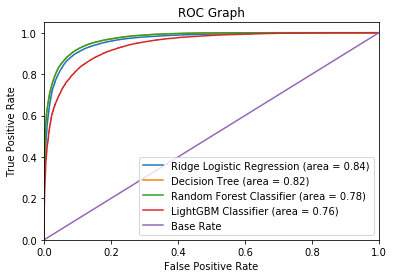

In [14]:
# Fit all three models
ridge = ridge.fit(X_train, y_train)
dt=dt.fit(X_train,y_train)
rf = rf.fit(X_train, y_train)
lgbc = lgbc.fit(X_train, y_train)

# Calculate roc_auc_score for each model prediction
ridge_auc = roc_auc_score(y_test, ridge.predict(X_test))
dt_auc= roc_auc_score(y_test, dt.predict(X_test))
rf_auc = roc_auc_score(y_test, rf.predict(X_test))
lgb_auc = roc_auc_score(y_test, lgbc.predict(X_test))

# Create ROC Graph
fpr, tpr, thresholds = roc_curve(y_test,ridge.predict_proba(X_test)[:, 1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(
    y_test, rf.predict_proba(X_test)[:, 1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(
    y_test, rf.predict_proba(X_test)[:, 1])
lgb_fpr, lgb_tpr, lgb_thresholds = roc_curve(
    y_test, lgbc.predict_proba(X_test)[:, 1])


plt.figure()

# Plot Ridge Logistic Regression ROC
plt.plot(fpr, tpr, label='Ridge Logistic Regression (area = %0.2f)' % ridge_auc)

# Plot Decision Tree  ROC
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.2f)' % dt_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_auc)


# Plot LGBM ROC
plt.plot(lgb_fpr, lgb_tpr, label='LightGBM Classifier (area = %0.2f)' % lgb_auc)


# Plot Base Rate ROC
plt.plot([0, 1], [0, 1], label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.savefig('ROC.png')
plt.show()

It's undoubted that ridge logistic regression performs the best with highest accuracy, F-1 Score and even ROC score.

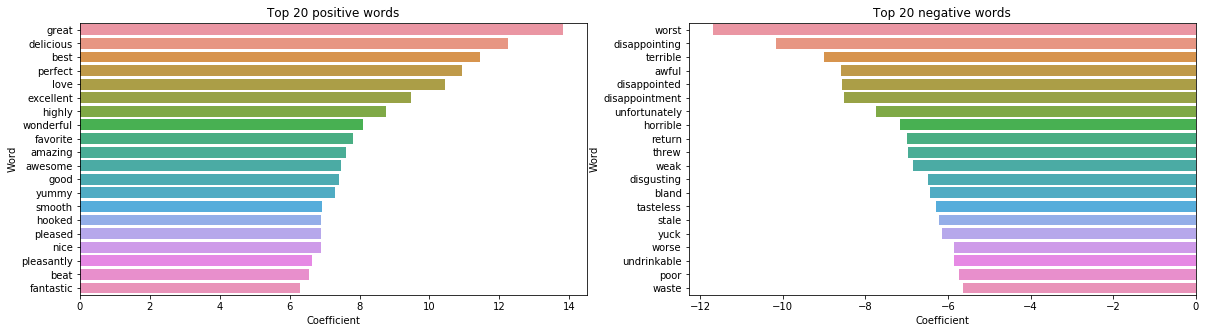

In [35]:
# visualize most important words to affect review rating according to our ridge model.
w = tfidf_vect.get_feature_names()
coef = ridge.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
plt.figure(figsize=(20,5))
plt.subplot(121)
sns.barplot(y='Word',x='Coefficient',data=coeff_df.head(20))
plt.title('Top 20 positive words')
plt.subplot(122)
sns.barplot(y='Word',x='Coefficient',data=coeff_df.tail(20), order=coeff_df.tail(20).sort_values('Coefficient',ascending = True).Word)
plt.title('Top 20 negative words')
plt.savefig('top 20 words.png')